# **1.Conectamos Colab con Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
PATH_ORIGEN = "/content/drive/MyDrive/Proyectos-independientes/Proyecto-MINSA/Dataset/Clasificacion/HGG-LGG"
os.chdir(PATH_ORIGEN)

In [3]:
%matplotlib inline
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
from random import shuffle
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation
import sys
import h5py
import utils

In [4]:
sys.path.append(os.path.abspath(PATH_ORIGEN))

In [5]:
# Frame size  
img_size = 224

img_size_touple = (img_size, img_size)

# Number of channels (RGB)
num_channels = 3

# Flat frame size
img_size_flat = img_size * img_size * num_channels

# Number of classes for classification (HGG-LGG)
num_classes = 2

# Number of files to train
_num_files_train = 1

# Number of frames per video
_images_per_file = 155

# Number of frames per training set
_num_images_train = _num_files_train * _images_per_file

# Video extension
video_exts = ".mp4"

In [6]:
in_dir = "/content/drive/MyDrive/Proyectos-independientes/Proyecto-MINSA/Dataset/Clasificacion/HGG-LGG/AVI"

# **2.Llamando funciones de Utils.py**

In [7]:
names, labels = utils.label_video_names(in_dir)

In [8]:
frames = utils.get_frames(in_dir, names[12])

In [9]:
visible_frame = (frames*255).astype('uint8')

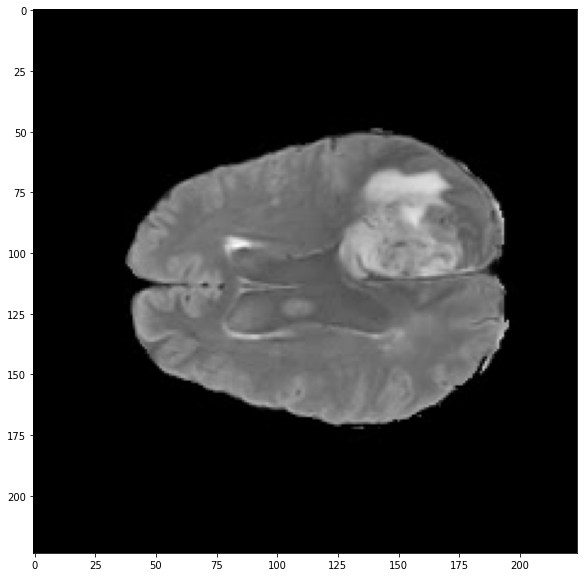

In [10]:
plt.figure(1,figsize = (10,10))
plt.imshow(visible_frame[85][:,:,2],cmap = 'gray')
plt.show()

# **3. Arquitectura de la CNN**

In [11]:
image_model = VGG16(include_top = True , weights = 'imagenet', input_shape = (224, 224,3))

553476096/553467096 [==============================] - 6s 0us/step


In [12]:
image_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
transfer_layer = image_model.get_layer('fc2')

In [14]:
image_model_transfer = Model(inputs=image_model.input, outputs=transfer_layer.output)

In [15]:
image_model_transfer.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [16]:
transfer_values_size = K.int_shape(transfer_layer.output)[1]

In [17]:
print("The input of the VGG16 net have dimensions:",K.int_shape(image_model.input)[1:3])
print("The output of the selecter layer of VGG16 net have dimensions: ", transfer_values_size)

The input of the VGG16 net have dimensions: (224, 224)
The output of the selecter layer of VGG16 net have dimensions:  4096


# **4.Train / Test**

In [18]:
# Training
training_set = int(len(names)*0.8)
names_training = names[0:training_set]
labels_training = labels[0:training_set]

In [19]:
# Test
test_set = int(len(names)*0.2)
names_test = names[training_set:]
labels_test = labels[training_set:]

In [20]:
# Generando Prueba.h5
utils.make_files(training_set, names_training, in_dir, labels_training,transfer_values_size,image_model_transfer)

- Progreso: 99.7%

In [25]:
# # Generando Pruebavalidation.h5
utils.make_files_test(test_set, names_test, in_dir, labels_test, transfer_values_size, image_model_transfer)

- Progreso: 98.6%

In [21]:
data, target = utils.process_alldata_training()

In [22]:
print(data[0].shape)
print(target[0].shape)

(155, 4096)
(2,)


In [23]:
print(len(data))
print(len(target))

295
295


In [26]:
data_test, target_test = utils.process_alldata_test()

In [27]:
print(data_test[0].shape)
print(target_test[0].shape)

(155, 4096)
(2,)


In [28]:
print(len(data_test))
print(len(target_test))

73
73


## **5.Arquitectura LSTM**

In [29]:
chunk_size = 4096
n_chunks = 155
rnn_size = 512 #### 100 neuronas

model = Sequential()

model.add(LSTM(rnn_size, input_shape=(n_chunks, chunk_size))) # RNN,GRU


model.add(Dense(1024))
model.add(Activation('relu'))

model.add(Dense(50))
model.add(Activation('sigmoid'))

model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics = ['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 512)               9439232   
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                51250     
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 102       
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0

In [31]:
# Dividimos prueba.h5 como train y validacion
print(len(data))
print(len(target))

295
295


In [39]:
print(data[0].shape)
print(data[1].shape)

(155, 4096)
(155, 4096)


In [43]:
print(len(data[0:5])) # 5 registros de resonancia magnética
print(len(data[0:5][0])) # tamaño de uno de estos registsros
print(len(data[0:])) # numero total de registros de resonancia magnética en Prueba.h5

5
155
295


In [45]:
# Numero de registros en Pruebavalidation.h5
total_train = len(data[0:])
train = int(total_train*0.8)
print("Numero de registros totales en Prueba.h5",total_train)
print("Numero de registros para entrenamiento",train)
print("Numero de registros totales en validation",total_train - train )

Numero de registros totales en Prueba.h5 295
Numero de registros para entrenamiento 236
Numero de registros totales en validation 59


In [46]:
# Entrenando
epoch = 20
batchS = 50

history = model.fit(np.array(data[0:train]), np.array(target[0:train]), epochs=epoch,
                    validation_data=(np.array(data[train:]), np.array(target[train:])), 
                    batch_size=batchS, verbose=1)

Epoch 1/20
5/5 [==============================] - 5s 522ms/step - loss: 0.5460 - accuracy: 0.7966 - val_loss: 0.5121 - val_accuracy: 0.7966
Epoch 2/20
5/5 [==============================] - 2s 383ms/step - loss: 0.5154 - accuracy: 0.7966 - val_loss: 0.5220 - val_accuracy: 0.7966
Epoch 3/20
5/5 [==============================] - 2s 380ms/step - loss: 0.5218 - accuracy: 0.7966 - val_loss: 0.5051 - val_accuracy: 0.7966
Epoch 4/20
5/5 [==============================] - 2s 374ms/step - loss: 0.5060 - accuracy: 0.7966 - val_loss: 0.5052 - val_accuracy: 0.7966
Epoch 5/20
5/5 [==============================] - 2s 384ms/step - loss: 0.5071 - accuracy: 0.7966 - val_loss: 0.5051 - val_accuracy: 0.7966
Epoch 6/20
5/5 [==============================] - 2s 379ms/step - loss: 0.5066 - accuracy: 0.7966 - val_loss: 0.5051 - val_accuracy: 0.7966
Epoch 7/20
5/5 [==============================] - 2s 376ms/step - loss: 0.5138 - accuracy: 0.7966 - val_loss: 0.5055 - val_accuracy: 0.7966
Epoch 8/20
5/5 [====

# **5.Métricas**

In [47]:
result = model.evaluate(np.array(data_test), np.array(target_test))

3/3 [==============================] - 0s 92ms/step - loss: 0.5277 - accuracy: 0.7808


In [48]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.527698278427124
accuracy 0.7808219194412231


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


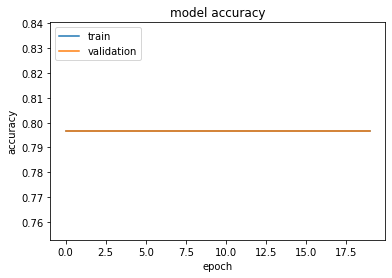

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


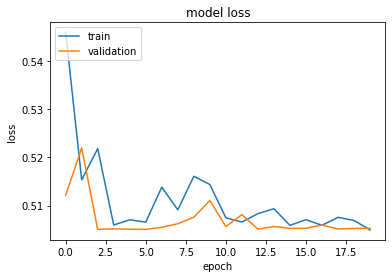

In [49]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path.eps', format='eps', dpi=1000)
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.show()